<a href="https://colab.research.google.com/github/EldarEyvazov/PolypSegmentation/blob/main/Unet_no_aug_finalipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

On this notebook we do not have data augmentation, baseline u net

In [ ]:
# Splitting data into train and test sets
from sklearn.model_selection import train_test_split
# Data and visualization
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:
pip install tf

  Preparing metadata (setup.py) ... done
  Created wheel for tf: filename=tf-1.0.0-py3-none-any.whl size=1260 sha256=ae2ee02d0daa08d6500a7cfff4ec7672f87f5c20f1fd937f7580f362f10c40c8
  Stored in directory: /root/.cache/pip/wheels/3f/c7/25/9e8467cbf247c674b122fbcf00d8fa558c314731cb511c19c5
Successfully built tf


In [ ]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Concatenate, UpSampling2D, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The subsequent step involves preprocessing the data, including normalizing the images and masks, as well as splitting the data into appropriate subsets. Initially, we will conduct an experiment to train the model without applying any data augmentation techniques. Following the acquisition of the initial results, we will implement various data augmentation strategies to enhance the model's performance further.








# Normalization / DataSpltting

In [ ]:
def split_data(images, masks, split=0.1):
    total_size = len(images)
    test_size  = int(split * total_size)
    valid_size = int(split * total_size)

    X_train, X_valid = train_test_split(images, test_size=valid_size, random_state=42)
    y_train, y_valid = train_test_split(masks, test_size=valid_size, random_state=42)

    X_train, X_test = train_test_split(X_train, test_size=test_size, random_state=42)
    y_train, y_test = train_test_split(y_train, test_size=test_size, random_state=42)
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

In [ ]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = split_data(images, masks)

print(f"train set size: {len(X_train)}\nvalid set size: {len(X_valid)}\ntest set size:  {len(X_test)}")

train set size: 800
valid set size: 100
test set size:  100


In [ ]:
# Find the maximum and minimum pixel values in the masks array
max_pixel_value = np.amax(masks)
min_pixel_value = np.amin(masks)

print("Maximum pixel value for the masks:", max_pixel_value)
print("Minimum pixel value for the masks:", min_pixel_value)



Maximum pixel value for the masks: 255
Minimum pixel value for the masks: 0


In [ ]:

# Rescale the pixel values of masks to the range [0, 1]
masks = masks / max_pixel_value

# Find the maximum and minimum pixel values in the rescaled masks array
max_rescaled_value = np.amax(masks)
min_rescaled_value = np.amin(masks)

print("Maximum rescaled pixel value for the masks:", max_rescaled_value)
print("Minimum rescaled pixel value for the masks:", min_rescaled_value)

Maximum rescaled pixel value for the masks: 1.0
Minimum rescaled pixel value for the masks: 0.0


In [ ]:
# Find the maximum and minimum pixel values in each channel of the images array
max_pixel_values = np.amax(images, axis=(0, 1, 2))  # Max value for each channel
min_pixel_values = np.amin(images, axis=(0, 1, 2))  # Min value for each channel

print("Maximum pixel values (R, G, B):", max_pixel_values)
print("Minimum pixel values (R, G, B):", min_pixel_values)


Maximum pixel values (R, G, B): [255 255 255]
Minimum pixel values (R, G, B): [0 0 0]


In [ ]:
# Rescale the pixel values of images to the range [0, 1] for each channel
images = images / 255.0

# Find the maximum and minimum pixel values in each channel of the rescaled images array
max_rescaled_values = np.amax(images, axis=(0, 1, 2))  # Max value for each channel
min_rescaled_values = np.amin(images, axis=(0, 1, 2))  # Min value for each channel

print("Maximum rescaled pixel values (R, G, B):", max_rescaled_values)
print("Minimum rescaled pixel values (R, G, B):", min_rescaled_values)

Maximum rescaled pixel values (R, G, B): [1. 1. 1.]
Minimum rescaled pixel values (R, G, B): [0. 0. 0.]


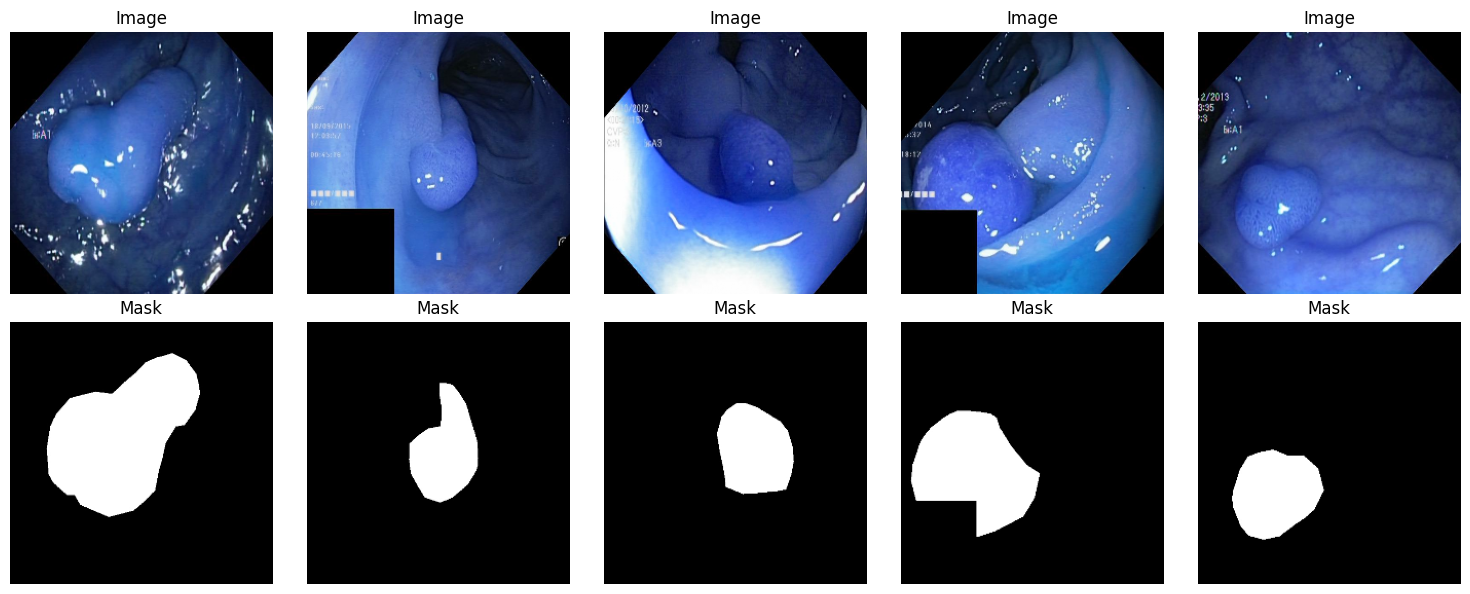

In [ ]:
import matplotlib.pyplot as plt
import random


# Set up the figure for plotting
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Randomly select 5 indices
random_indices = random.sample(range(len(images)), 5)

# Plot the images and masks
for i, idx in enumerate(random_indices):
    # Plot the image
    axes[0, i].imshow(images[idx])
    axes[0, i].set_title("Image")
    axes[0, i].axis("off")

    # Plot the mask
    axes[1, i].imshow(masks[idx], cmap='gray')
    axes[1, i].set_title("Mask")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
X_train[0].shape

(256, 256, 3)

In [ ]:
#defining our model architecture, using dropout
def Unet(input_shape):

    # Encode
    inputs = Input(input_shape)

    layer1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    # layer5 = Dropout(0.5)(layer1)
    layer1 = Conv2D(16, [3, 3], activation='relu', kernel_initializer='he_normal', padding='same')(layer1)
    pool1  = MaxPooling2D(pool_size=(2, 2))(layer1)

    layer2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    # layer5 = Dropout(0.5)(layer2)
    layer2 = Conv2D(32, [3, 3], activation='relu', kernel_initializer='he_normal', padding='same')(layer2)
    pool2  = MaxPooling2D(pool_size=(2, 2))(layer2)

    layer3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    # layer5 = Dropout(0.3)(layer3)
    layer3 = Conv2D(64, [3, 3], activation='relu', kernel_initializer='he_normal', padding='same')(layer3)
    pool3  = MaxPooling2D(pool_size=(2, 2))(layer3)

    layer4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    # layer5 = Dropout(0.3)(layer4)
    layer4 = Conv2D(128, [3, 3], activation='relu', kernel_initializer='he_normal', padding='same')(layer4)
    pool4  = MaxPooling2D(pool_size=(2, 2))(layer4)

    # Buttleneck
    layer5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    layer5 = Dropout(0.3)(layer5)
    layer5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer5)


    # Decoder
    upsam1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(layer5)
    upsam1 = Concatenate()([upsam1, layer4])
    layer6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsam1)

    upsam2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(layer6)
    upsam2 = Concatenate()([upsam2, layer3])
    layer7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsam2)

    upsam3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(layer7)
    upsam3 = Concatenate()([upsam3, layer2])
    layer8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsam3)

    upsam4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(layer8)
    upsam4 = Concatenate()([upsam4, layer1])
    layer9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsam4)

    # Output
    layer10= Conv2D(1, (1, 1), activation='sigmoid')(layer9)

    model = Model(inputs=inputs, outputs=layer10)

    return model

In [ ]:
model = Unet((256, 256, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define custom metrics
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, 'float32')  # Ensure y_true is float32
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [ ]:

# Ensure masks are binary
y_train = (y_train > 0).astype('float32')
y_valid = (y_valid > 0).astype('float32')
y_test = (y_test > 0).astype('float32')


In [ ]:
import tensorflow as tf
import csv
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K

# Custom callback to save metrics to CSV
class CSVLogger(Callback):
    def __init__(self, filename, separator=',', append=False):
        super(CSVLogger, self).__init__()
        self.sep = separator
        self.filename = filename
        self.append = append
        self.csv_file = None
        self.writer = None
        self.keys = None
        self.append_header = True

    def on_train_begin(self, logs=None):
        if self.append:
            if tf.io.gfile.exists(self.filename):
                with open(self.filename, 'r') as f:
                    self.append_header = not bool(len(f.readline()))
            mode = 'a'
        else:
            mode = 'w'

        self.csv_file = open(self.filename, mode, newline='')
        self.writer = csv.DictWriter(self.csv_file, fieldnames=None, delimiter=self.sep)
        self.keys = None

    def on_epoch_end(self, epoch, logs=None):
        if not self.keys:
            self.keys = sorted(logs.keys())
            self.writer.fieldnames = ['epoch'] + self.keys
            if self.append_header:
                self.writer.writeheader()

        row_dict = {'epoch': epoch}
        row_dict.update((key, logs[key]) for key in self.keys)
        self.writer.writerow(row_dict)
        self.csv_file.flush()

    def on_train_end(self, logs=None):
        if self.csv_file:
            self.csv_file.close()
            self.csv_file = None
            self.writer = None
            self.keys = None


import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def train_model(model, X_train, y_train, X_valid, y_valid, batch_size, epochs, save_path, csv_log_path):
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=dice_loss,
                  metrics=['accuracy', iou_coef, dice_coef])

    # Define callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    csv_logger = CSVLogger(filename=csv_log_path)

    # Train the model
    history = model.fit(X_train, y_train,
                        validation_data=(X_valid, y_valid),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[reduce_lr, early_stopping, csv_logger])

    # Save the model
    model.save(save_path)

    return history
# Paths for saving metrics and the model
csv_log_path = '/content/drive/MyDrive/Vision Cognitive systems/Kvasir-SEG no augmentation/results/unet_no_aug/training_metrics_unet_no_aug.csv'
save_path = '/content/drive/MyDrive/Vision Cognitive systems/Kvasir-SEG no augmentation/results/unet_no_aug'

# Train the model
history = train_model(model, X_train, y_train, X_valid, y_valid, batch_size=12, epochs=60, save_path=save_path, csv_log_path=csv_log_path)


In [ ]:
loss, accuracy, iou, dice = model.evaluate(X_test, y_test,batch_size=8)
print(f'Test Loss: {loss}\nTest Accuracy: {accuracy}\nIoU: {iou}\nDice: {dice}')

In [ ]:
predictions = model.predict(X_test,batch_size=8)

In [ ]:
# Plot the test images, test masks, and predicted masks
num_images = 10
plt.figure(figsize=(20, 8))

for i in range(num_images):
    # Plot test images
    plt.subplot(3, num_images, i + 1)
    img_rgb = X_test[i] if X_test[i].shape[-1] == 3 else np.stack([X_test[i]]*3, axis=-1)
    plt.imshow(img_rgb)
    plt.title('Test Image')
    plt.axis('off')

    # Plot test masks
    plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(y_test[i].squeeze(), cmap='viridis')
    plt.title('Test Mask')
    plt.axis('off')

    # Plot predicted masks
    plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(predictions[i].squeeze(), cmap='viridis')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_accuracy, test_iou, test_dice = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}\nIoU: {test_iou}\nDice: {test_dice}')

# Generate predictions on the test set
predictions = model.predict(X_test)

# Extract metrics from the history object
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
iou = history_dict['iou_coef']
val_iou = history_dict['val_iou_coef']
dice = history_dict['dice_coef']
val_dice = history_dict['val_dice_coef']

epochs = range(1, len(loss) + 1)

# Create lists for test metrics to match the number of epochs
test_loss_list = [test_loss] * len(epochs)
test_accuracy_list = [test_accuracy] * len(epochs)
test_iou_list = [test_iou] * len(epochs)
test_dice_list = [test_dice] * len(epochs)

# Plot training, validation, and test metrics
plt.figure(figsize=(20, 6))

# Subplot 1: Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, loss, label='Training loss', color='blue', linestyle='--')
plt.plot(epochs, val_loss, label='Validation loss', color='red')
plt.plot(epochs, test_loss_list, label='Test loss', color='green', linestyle=':')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, accuracy, label='Training accuracy', color='blue', linestyle='--')
plt.plot(epochs, val_accuracy, label='Validation accuracy', color='red')
plt.plot(epochs, test_accuracy_list, label='Test accuracy', color='green', linestyle=':')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Subplot 3: IoU and Dice Coefficient
plt.subplot(1, 3, 3)
plt.plot(epochs, iou, label='Training IoU', color='blue', linestyle='--')
plt.plot(epochs, val_iou, label='Validation IoU', color='red')
plt.plot(epochs, test_iou_list, label='Test IoU', color='green', linestyle=':')
plt.plot(epochs, dice, label='Training Dice Coefficient', color='blue', linestyle='--')
plt.plot(epochs, val_dice, label='Validation Dice Coefficient', color='red')
plt.plot(epochs, test_dice_list, label='Test Dice Coefficient', color='green', linestyle=':')
plt.title('Training, Validation, and Test IoU & Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Coefficient')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
iou = history_dict['iou_coef']
val_iou = history_dict['val_iou_coef']
dice = history_dict['dice_coef']
val_dice = history_dict['val_dice_coef']

epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(20, 6))

# Subplot 1: Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, loss, label='Training loss', color='blue', linestyle='--')
plt.plot(epochs, val_loss, label='Validation loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, accuracy, label='Training accuracy', color='blue', linestyle='--')
plt.plot(epochs, val_accuracy, label='Validation accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Subplot 3: IoU and Dice Coefficient
plt.subplot(1, 3, 3)
plt.plot(epochs, iou, label='Training IoU', color='green', linestyle='--')
plt.plot(epochs, val_iou, label='Validation IoU', color='orange')
plt.plot(epochs, dice, label='Training Dice Coefficient', color='blue', linestyle='--')
plt.plot(epochs, val_dice, label='Validation Dice Coefficient', color='red')
plt.title('Training and Validation IoU & Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Coefficient')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
